<a href="https://colab.research.google.com/github/swilsonmfc/unsupervised/blob/main/KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KMeans

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import yellowbrick
import yellowbrick.datasets
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

# Data

## Random Blobs

In [2]:
X_blob, y_blob = make_blobs(n_samples = 500, centers = 5, cluster_std=1.5, random_state=538)

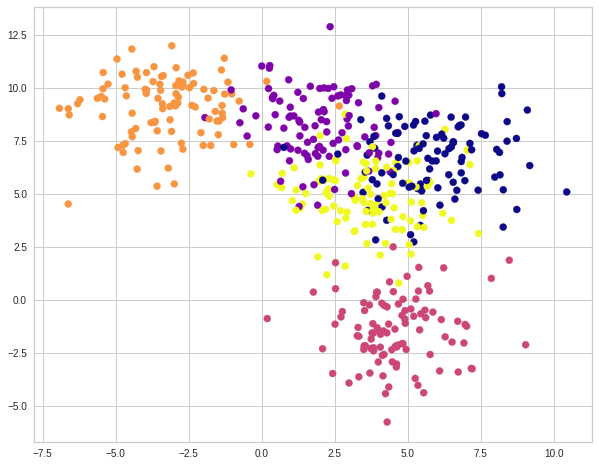

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:,0], X_blob[:,1], s=50, c=y_blob, cmap='plasma');

# Metrics
* Supervised learning
  * Precision and Recall
  * Awkward to use these for Unsupervised learning
  * If you have the labels use Supervised
* What makes a good cluster?
  * High Intra-Cluster Similarity (cohesiveness within cluster)
  * Low Inter-Cluster Similarity (distinctiveness between clusters)

## Homogeneity
* Ground Truth is known
* Measures the degree to which each cluster has members of the same class
* 0.0 Poor - 1.0 Perfect

## Completeness
* Ground Truth is known
* Measures the degree to which all members of a given class are assigned to the same cluster
* 0.0 Poor - 1.0 Perfect


## Silhouette Coefficient
* Ground Truth not known
* a: Mean distance between sample & all other points in same class
* b: Mean distance between sample & all other points in the next nearest cluster
* Formula:  (b-a) / max(a,b)
* Scores:
  * Range -1 to 1
  * 1 = Perfect separation of clusters
  * 0 = Clusters overlap
  * Negative = Likely bad clusters

In [4]:
results_df = pd.DataFrame(columns=['Homogeneity', 'Completeness', 'Silhouette'])

def accuracy(X, labels, truth=None):
    score_silhouette   = silhouette_score(X, labels, metric='euclidean')
    print('Silhouette   : {:.3f}'.format(score_silhouette))
    
    score_homogeneity = None
    score_completeness = None
    if truth is not None:
        score_homogeneity  = homogeneity_score(labels, truth)
        score_completeness = completeness_score(labels, truth)   
        print('Homogeneity  : {:.3f}'.format(score_homogeneity))
        print('Completeness : {:.3f}'.format(score_completeness))
    
    return score_homogeneity, score_completeness, score_silhouette

def score_model(name, X, labels, truth):
    score = accuracy(X, labels, truth)
    results_df.loc[name] = [*score]

# KMeans
* Three main steps:
  * Pick initial centroids
  * Iteratively
    * Assign points to closest centroid
    * Update centroids
  * Converge when centroids / labels do not change
* Workhorse of clustering

## EM Algorithm
* KMeans can be framed like Expectation Maximization (Lloyd's Algorithm)
* E = Assign to closes centroid
* M = Update centroids

In [5]:
def initialize(X, pick, seed):
    generator = np.random.seed(seed)
    indexes = np.random.choice(X.shape[0], pick, replace=False)
    return X[indexes]

def assignClusters(X, centroids):
    return pairwise_distances_argmin(X, centroids)
    
def computeCentroids(X, labels, clusters):
    return np.array( [X[labels == index].mean(0) for index in range(clusters)] )
    
def clusterData(X, clusters, seed=1337, iterations=50):
    iteration = 0
    converged = False
    centroids = initialize(X, clusters, seed)
    
    while not converged:
        assignment = assignClusters(X, centroids)
        updated    = computeCentroids(X, assignment, clusters)
        if np.all(centroids == updated) or iteration > iterations:
            converged = True
        centroids = updated
        iteration += 1
        
    return centroids, assignment

In [6]:
@interact
def ExpectationMax(EM_CLUSTERS=7):
    EM_centroids, EM_labels = clusterData(X_blob, EM_CLUSTERS)
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=EM_labels, s=50, cmap='plasma')
    plt.scatter(EM_centroids[:, 0], EM_centroids[:, 1], s=100, c='gray')
    score_model('EM', X_blob, EM_labels, y_blob)

interactive(children=(IntSlider(value=7, description='EM_CLUSTERS', max=21, min=-7), Output()), _dom_classes=(…

## SKLearn

In [7]:
@interact
def SKLearnKMeans(SK_clusters=7):
    km = KMeans(n_clusters=SK_clusters)
    SK_labels = km.fit_predict(X_blob, y_blob)
    SK_centroids = computeCentroids(X_blob, SK_labels, SK_clusters)
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=SK_labels, s=50, cmap='plasma')
    plt.scatter(SK_centroids[:, 0], SK_centroids[:, 1], s=100, c='gray')
    score_model('KMeans', X_blob, SK_labels, y_blob)

interactive(children=(IntSlider(value=7, description='SK_clusters', max=21, min=-7), Output()), _dom_classes=(…

# Limitations
* Costly computation O(kN), switch to MiniBatchKMeans for large datasets
* You need to know how many clusters (run the algorithm many times)
* Non-convex clusters are hard for KMeans to identify
* Guarantee to converge, but couold be in local minima (kmeans++)

# Selecting K
* When we have to provide the number of clusters, what's a good value?

## Elbow Method
* Distortion
  * Average of squared distance between point and assigned centroid

In [8]:
@interact
def Elbow(Method=['distortion', 'silhouette', 'calinski_harabasz']):
    plt.figure(figsize=(10, 8))
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric=Method, locate_elbow=True)
    visualizer.fit(X_blob)

interactive(children=(Dropdown(description='Method', options=('distortion', 'silhouette', 'calinski_harabasz')…

## Silhouette
* Recall - Silhoutte Coefficient
  * Measures how similar an object is to those in its cluster vs the nearest cluster
  * Scores range -1 to 1
  * 1 represents a good cluster, -1 poor clustering
* Look for:
  * Average Score
  * Width of Clusters
  * Fluctuations of Clusters
  * Clusters below the Average

In [9]:
@interact
def Elbow(Clusters=(2,10)):
    plt.figure(figsize=(10, 8))
    model = KMeans(Clusters)
    visualizer = SilhouetteVisualizer(model, colors='plasma')
    visualizer.fit(X_blob)

interactive(children=(IntSlider(value=6, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

## Intercluster Distance Map
* Visualization that displays a 2D embedding
* Preserves the distance to other centers
* Closer they are in visualization mirrors closeness in feature space
* Sized by membership in cluster
* Note:  Overlaps in visualization don't mean overlapping clusters

In [10]:
@interact
def Interdistance(Clusters=(2,10)):
    plt.figure(figsize=(10, 8))
    model = KMeans(Clusters)
    visualizer = InterclusterDistance(model, colors='plasma')
    visualizer.fit(X_blob)

interactive(children=(IntSlider(value=6, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

In [11]:
@interact
def showResults(SORT=['Completeness', 'Homogeneity', 'Silhouette']):
    print(results_df.sort_values(SORT, ascending=False))

interactive(children=(Dropdown(description='SORT', options=('Completeness', 'Homogeneity', 'Silhouette'), valu…

# Performance
* Scikit KMeans > scipy KMeans 
* Requires # of clusters


# Multiple Dimensions
* With multiple dimensions you're flying by instrument
* We'll use a credit dataset - 24 values
* Approach
  * **Scale / Preprocess the Data**
  * Check out # of Clusters
  * Fit & Score KMeans
  * Visualize with PCA

## Load Data

In [12]:
credit = yellowbrick.datasets.load_credit(return_dataset=True)
credit_df = credit.to_dataframe()
credit_df.head()

,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,aug_delay,...,jul_bill,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Scale Data

In [13]:
scaler = StandardScaler()
credit_df = pd.DataFrame(scaler.fit_transform(credit_df), columns=credit_df.columns)

## Elbow

In [14]:
@interact
def CreditElbow(Method=['distortion', 'silhouette', 'calinski_harabaz']):
    plt.figure(figsize=(10, 8))
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric=Method, locate_elbow=True)
    visualizer.fit(credit_df)

interactive(children=(Dropdown(description='Method', options=('distortion', 'silhouette', 'calinski_harabaz'),…

## Run KMeans

In [15]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict(credit_df)

In [16]:
cnt = Counter()
for x in clusters:
    cnt[x] += 1
cnt

Counter({0: 13866, 2: 3331, 3: 9492, 1: 3311})

In [17]:
scores = accuracy(credit_df, clusters)

Silhouette   : 0.153


## Visualize with PCA

Text(0.5, 1.0, 'First 2 Principal Components - Credit (44.8% Variance Explained)')

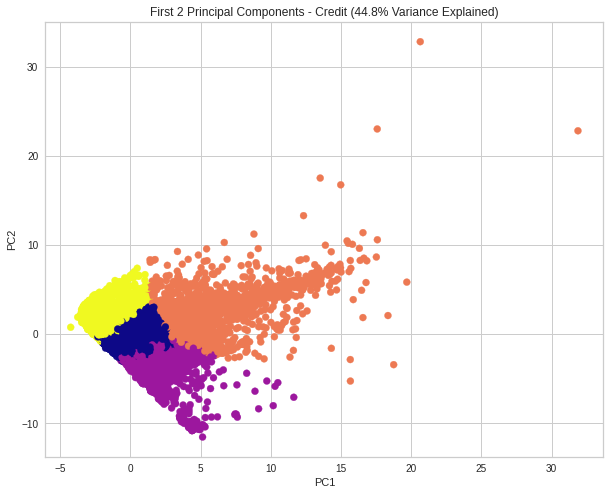

In [18]:
pca2d = PCA(n_components=2)
pcs = pd.DataFrame(pca2d.fit_transform(credit_df))
plotDF = pd.DataFrame(columns=['PC1', 'PC2', 'Cluster'])
plotDF['PC1'] = pcs[0]
plotDF['PC2'] = pcs[1]
plotDF['Cluster'] = clusters

plt.figure(figsize=(10,8))
plt.scatter(x=plotDF.PC1, y=plotDF.PC2, c=plotDF.Cluster, cmap='plasma')
plt.xlabel('PC1')
plt.ylabel('PC2')
percent_explained = sum(pca2d.explained_variance_ratio_) * 100.
plt.title('First 2 Principal Components - Credit ({:.1f}% Variance Explained)'.format(percent_explained))


## Explore Data

In [19]:
clustered_df = credit_df.copy()
clustered_df['cluster'] = clusters
grouping = clustered_df.groupby('cluster').mean()
sizes    = clustered_df.groupby('cluster').size()
grouping = grouping.reset_index()
grouping['size'] = sizes
grouping

,cluster,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,...,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay,default,size
0,0,-0.358787,-0.022023,0.140203,0.114102,-0.124689,0.085453,0.173664,0.212439,0.218047,...,-0.122273,-0.124802,-0.070489,-0.066339,-0.083366,-0.083640,-0.088371,-0.080318,-0.164923,13866
1,1,-0.710520,-0.109270,0.193853,-0.037745,-0.036058,1.469638,1.651161,1.626968,1.599768,...,-0.044708,-0.027852,-0.212793,-0.168241,-0.190558,-0.194933,-0.188733,-0.184147,1.191640,3311
2,2,0.937446,-0.068151,-0.066013,-0.085277,0.173682,0.197853,0.258435,0.263529,0.284269,...,2.178435,2.126126,0.671823,0.530986,0.603478,0.555700,0.564891,0.486723,-0.109086,3331
3,3,0.442988,0.094204,-0.249264,-0.123590,0.133775,-0.706902,-0.920340,-0.970332,-0.976314,...,-0.570259,-0.554088,-0.058563,-0.030742,-0.023525,-0.004832,-0.003309,0.010759,-0.136465,9492


In [20]:
difference = grouping.max(axis=0)-grouping.min(axis=0)
print(difference)

cluster          3.000000
limit            1.647966
sex              0.203474
edu              0.443117
married          0.237692
age              0.298372
apr_delay        2.176539
may_delay        2.571502
jun_delay        2.597300
jul_delay        2.576082
aug_delay        2.478461
sep_delay        2.305652
apr_bill         2.669266
may_bill         2.752710
jun_bill         2.769972
jul_bill         2.795763
aug_bill         2.748694
sep_bill         2.680214
apr_pay          0.884616
may_pay          0.699227
jun_pay          0.794036
jul_pay          0.750633
aug_pay          0.753624
sep_pay          0.670871
default          1.356563
size         10555.000000
dtype: float64


Text(0.5, 1.0, 'Clusters - July Bill & Credit Limit')

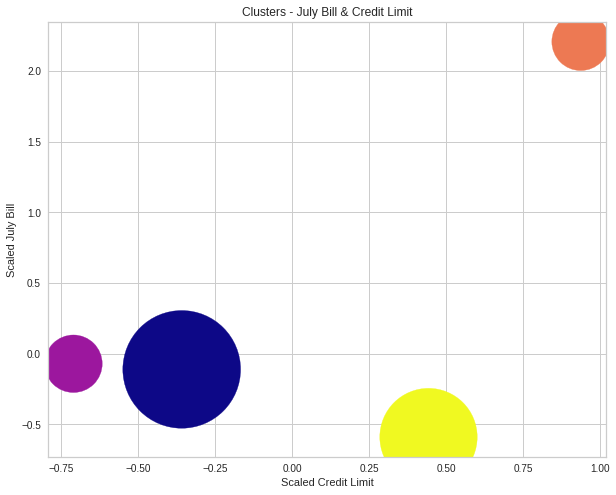

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(x=grouping['limit'], y=grouping['jul_bill'], c=grouping['cluster'], cmap='plasma', s=grouping['size'])
plt.ylabel('Scaled July Bill')
plt.xlabel('Scaled Credit Limit')
plt.title('Clusters - July Bill & Credit Limit')

# Tips
* Be mindful of the dataset size
  * Small < 100,000 KMeans
  * Very Large > 100,000 MiniBatchKMeans
* Know KMeans characteristics & weaknesses
  * Know # clusters
  * Non-convex clusters
  * Mini-batch for huge datasets
  * Will converge - but could be a local minima
  * Use kmeans++ (ensures starting centroids are distant)
* Multiple Dimensions
  * Scale Data
  * Visualize with PCA / T-SNE, UMAP